In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d AnalyzeBoston/crimes-in-boston

Saving kaggle.json to kaggle.json
  0% 0.00/10.5M [00:00<?, ?B/s]
100% 10.5M/10.5M [00:00<00:00, 133MB/s]


**UNZIPPING THE FILES**

In [ ]:
!unzip crimes-in-boston.zip

Archive:  crimes-in-boston.zip
  inflating: crime.csv               
  inflating: offense_codes.csv       


**DOWNLOADING MODULES**

In [ ]:
!pip -q install pytorch_tabnet
!pip -q install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 KB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 10.1 MB/s eta 0:00:00


**IMPORTING MODULES**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import folium

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D

import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn import preprocessing
import xgboost as xgb
from sklearn import model_selection
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
import pytorch_tabnet
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from yellowbrick.classifier import ClassificationReport



import warnings
warnings.filterwarnings('ignore')

**IMPORTING CSV**

In [ ]:
train_df = pd.read_csv("crime.csv",encoding='latin-1')
train_df.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,I182070945,619,Larceny,LARCENY ALL OTHERS,D14,808,NaN,2018-09-02 13:00:00,2018,9,Sunday,13,Part One,LINCOLN ST,42.357791,-71.139371,"(42.35779134, -71.13937053)"
1,I182070943,1402,Vandalism,VANDALISM,C11,347,NaN,2018-08-21 00:00:00,2018,8,Tuesday,0,Part Two,HECLA ST,42.306821,-71.060300,"(42.30682138, -71.06030035)"
2,I182070941,3410,Towed,TOWED MOTOR VEHICLE,D4,151,NaN,2018-09-03 19:27:00,2018,9,Monday,19,Part Three,CAZENOVE ST,42.346589,-71.072429,"(42.34658879, -71.07242943)"
3,I182070940,3114,Investigate Property,INVESTIGATE PROPERTY,D4,272,NaN,2018-09-03 21:16:00,2018,9,Monday,21,Part Three,NEWCOMB ST,42.334182,-71.078664,"(42.33418175, -71.07866441)"
4,I182070938,3114,Investigate Property,INVESTIGATE PROPERTY,B3,421,NaN,2018-09-03 21:05:00,2018,9,Monday,21,Part Three,DELHI ST,42.275365,-71.090361,"(42.27536542, -71.09036101)"


In [ ]:
print("Shape of training data : ",train_df.shape)

Shape of training data :  (319073, 17)


**Data Preprocessing**

**DROP UNNECESSARY COLUMNS**

In [ ]:
train_df = train_df.drop(['INCIDENT_NUMBER','OFFENSE_CODE','OFFENSE_DESCRIPTION','YEAR','OCCURRED_ON_DATE','Location','UCR_PART'],axis=1)

In [ ]:
train_df.head()

,OFFENSE_CODE_GROUP,DISTRICT,REPORTING_AREA,SHOOTING,MONTH,DAY_OF_WEEK,HOUR,STREET,Lat,Long
0,Larceny,D14,808,NaN,9,Sunday,13,LINCOLN ST,42.357791,-71.139371
1,Vandalism,C11,347,NaN,8,Tuesday,0,HECLA ST,42.306821,-71.060300
2,Towed,D4,151,NaN,9,Monday,19,CAZENOVE ST,42.346589,-71.072429
3,Investigate Property,D4,272,NaN,9,Monday,21,NEWCOMB ST,42.334182,-71.078664
4,Investigate Property,B3,421,NaN,9,Monday,21,DELHI ST,42.275365,-71.090361


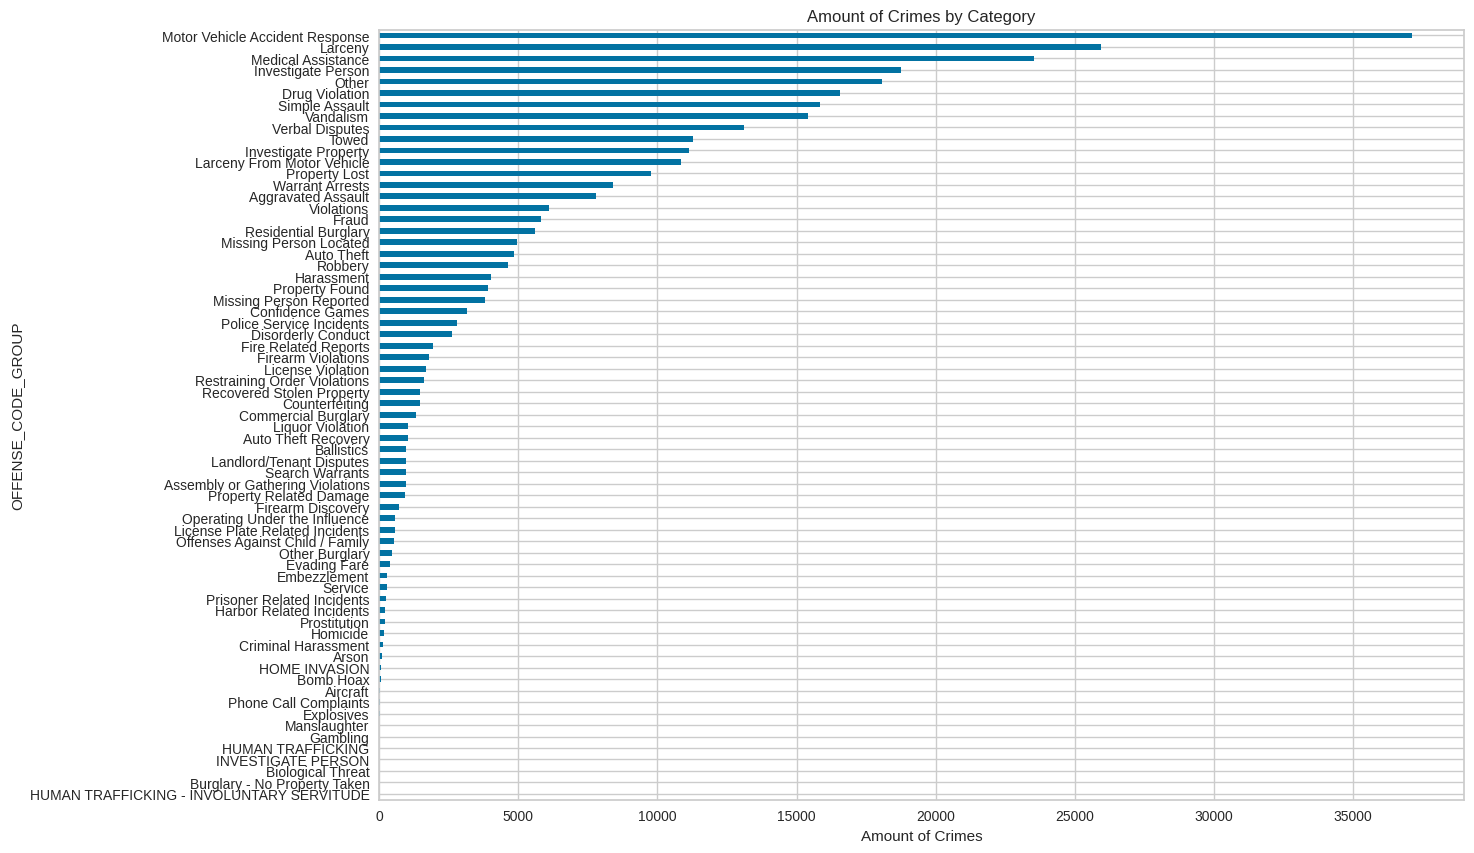

In [ ]:

# Plot Bar Chart for visualizing Category
plt.figure(figsize=(14,10))
plt.title('Amount of Crimes by Category')
plt.ylabel('Crime Category')
plt.xlabel('Amount of Crimes')

train_df.groupby([train_df['OFFENSE_CODE_GROUP']]).size().sort_values(ascending=True).plot(kind='barh')

plt.show()


In [ ]:
# At previous plot, we could see that the classes is quite imbalance
# Therefore, we are going to group several less occured Crime Type into 'Others' to reduce the Target Class amount

# First, we sum up the amount of Crime Type happened and select the last 13 classes
all_classes = train_df.groupby(['OFFENSE_CODE_GROUP'])['DISTRICT'].size().reset_index()
all_classes['Amt'] = all_classes['DISTRICT']
all_classes = all_classes.drop(['DISTRICT'], axis=1)
all_classes = all_classes.sort_values(['Amt'], ascending=[False])

unwanted_classes = all_classes.tail(30)
unwanted_classes

,OFFENSE_CODE_GROUP,Amt
33,Landlord/Tenant Disputes,968
59,Search Warrants,966
3,Assembly or Gathering Violations,955
53,Property Related Damage,912
20,Firearm Discovery,698
45,Operating Under the Influence,574
36,License Plate Related Incidents,560
44,Offenses Against Child / Family,545
47,Other Burglary,461
17,Evading Fare,407


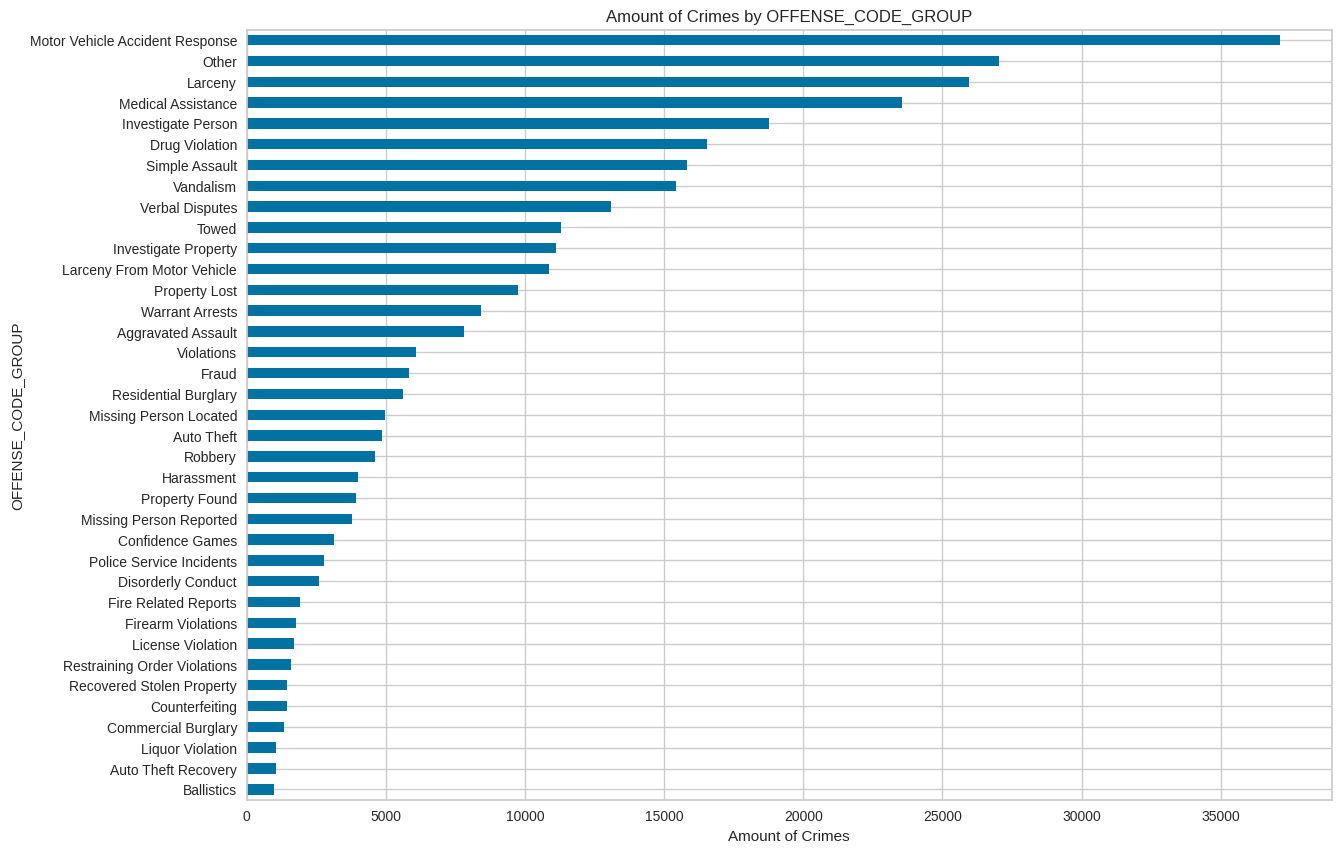

In [ ]:
# After that, we replaced it with label 'OTHERS'
train_df.loc[train_df['OFFENSE_CODE_GROUP'].isin(unwanted_classes['OFFENSE_CODE_GROUP']), 'OFFENSE_CODE_GROUP'] = 'Other'

# Plot Bar Chart visualize Primary Types
plt.figure(figsize=(14,10))
plt.title('Amount of Crimes by OFFENSE_CODE_GROUP')
plt.ylabel('Crime Type')
plt.xlabel('Amount of Crimes')

train_df.groupby([train_df['OFFENSE_CODE_GROUP']]).size().sort_values(ascending=True).plot(kind='barh')

plt.show()

In [ ]:
Classes = train_df['OFFENSE_CODE_GROUP'].unique()
Classes

array(['Larceny', 'Vandalism', 'Towed', 'Investigate Property',
       'Motor Vehicle Accident Response', 'Auto Theft', 'Verbal Disputes',
       'Robbery', 'Fire Related Reports', 'Other', 'Property Lost',
       'Medical Assistance', 'Larceny From Motor Vehicle',
       'Residential Burglary', 'Simple Assault',
       'Restraining Order Violations', 'Violations', 'Harassment',
       'Ballistics', 'Property Found', 'Police Service Incidents',
       'Drug Violation', 'Warrant Arrests', 'Disorderly Conduct',
       'Missing Person Reported', 'Investigate Person', 'Fraud',
       'Aggravated Assault', 'Firearm Violations', 'Counterfeiting',
       'Liquor Violation', 'Missing Person Located',
       'Auto Theft Recovery', 'Confidence Games', 'License Violation',
       'Commercial Burglary', 'Recovered Stolen Property'], dtype=object)

In [ ]:
#Encode target labels into categorical variables:
train_df['OFFENSE_CODE_GROUP'] = pd.factorize(train_df['OFFENSE_CODE_GROUP'])[0]
train_df['OFFENSE_CODE_GROUP'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36])

**CONVERTING NAN to 0**

In [ ]:
train_df['SHOOTING'].value_counts()

Y    1019
Name: SHOOTING, dtype: int64

In [ ]:
train_df['SHOOTING'] = train_df['SHOOTING'].replace(np.nan, 0)
train_df['SHOOTING'] = train_df['SHOOTING'].replace('Y', 1)

In [ ]:
train_df['SHOOTING'].value_counts()

0    318054
1      1019
Name: SHOOTING, dtype: int64

**LABEL ENCODING FEATURES**

In [ ]:
train_df.columns

Index(['OFFENSE_CODE_GROUP', 'DISTRICT', 'REPORTING_AREA', 'SHOOTING', 'MONTH',
       'DAY_OF_WEEK', 'HOUR', 'STREET', 'Lat', 'Long'],
      dtype='object')

In [ ]:
#Encode target labels into categorical variables:
train_df['DISTRICT'] = pd.factorize(train_df['DISTRICT'])[0]
train_df['REPORTING_AREA'] = pd.factorize(train_df['REPORTING_AREA'])[0]
train_df['MONTH'] = pd.factorize(train_df['MONTH'])[0]
train_df['DAY_OF_WEEK'] = pd.factorize(train_df['DAY_OF_WEEK'])[0]
train_df['HOUR'] = pd.factorize(train_df['HOUR'])[0]
train_df['STREET'] = pd.factorize(train_df['STREET'])[0]

CORRELATION

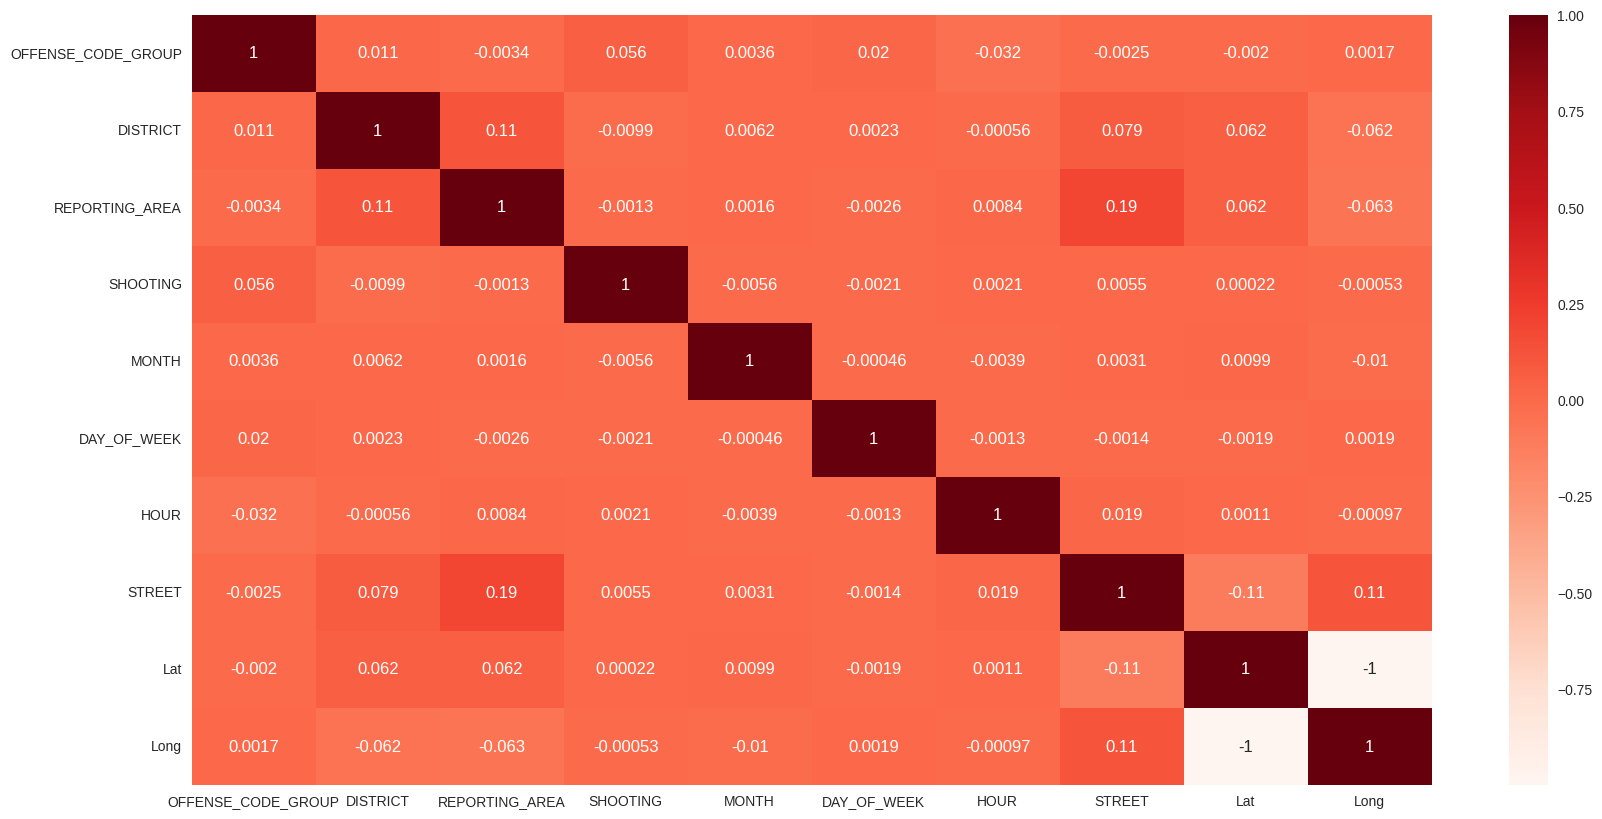

In [ ]:
#Using Pearson Correlation
plt.figure(figsize=(20,10))
cor = train_df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

**REMOVING NAN VALUES FROM COORDINATES**

In [ ]:
train_df = train_df.dropna()

X_fs = train_df.drop(['OFFENSE_CODE_GROUP'], axis=1)
Y_fs = train_df['OFFENSE_CODE_GROUP']

**TRAIN TEST SPLIT**

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_fs, Y_fs,test_size = 0.2, random_state= 42)

**NORMALIZING DATA**

In [ ]:
from sklearn.preprocessing import StandardScaler
sc= StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

**RANDOM FOREST**

========== Random Forest Results ==========
Accuracy    :  0.1989634707013291
Recall      :  0.1989634707013291
Precision   :  0.23635590340145363
F1 Score    :  0.1989634707013291
Confusion Matrix: 
[[2536   31  185 ...    9    0    0]
 [ 276   86  157 ...    0    0    0]
 [ 174   31  821 ...    1    0    0]
 ...
 [ 110    2    2 ...   17    0    0]
 [  76    5   20 ...    0    0    0]
 [  51    1   10 ...    0    0    0]]
================= Classification Report =================

                                 precision    recall  f1-score   support

                        Larceny       0.28      0.49      0.35      5195
                      Vandalism       0.11      0.03      0.05      2934
                          Towed       0.28      0.37      0.32      2207
           Investigate Property       0.42      0.12      0.19      2093
Motor Vehicle Accident Response       0.18      0.57      0.27      6204
                     Auto Theft       0.22      0.01      0.02       865
 

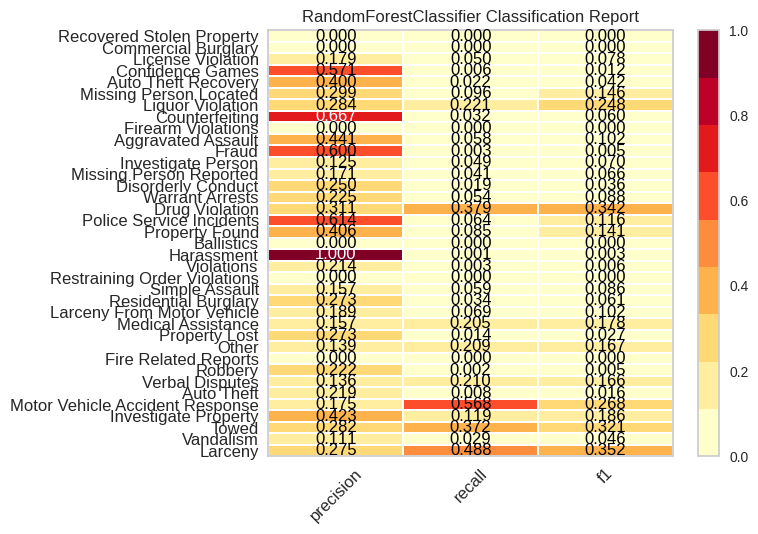

In [ ]:
rf_model = RandomForestClassifier(n_estimators=200, # Number of trees
                                  min_samples_split = 30,
                                  bootstrap = True,
                                  max_depth = 150,
                                  min_samples_leaf = 25)

# Model Training
rf_model.fit(X=X_train,
             y=y_train)

# Prediction
result = rf_model.predict(X_test)

y_pred_prob_rf = rf_model.predict_proba(X_test)
df_rf_prob = pd.DataFrame(y_pred_prob_rf,columns=Classes)

ac_sc = accuracy_score(y_test, result)
rc_sc = recall_score(y_test, result, average="weighted")
pr_sc = precision_score(y_test, result, average="weighted")
f1_sc = f1_score(y_test, result, average='micro')
confusion_m = confusion_matrix(y_test, result)

print("========== Random Forest Results ==========")
print("Accuracy    : ", ac_sc)
print("Recall      : ", rc_sc)
print("Precision   : ", pr_sc)
print("F1 Score    : ", f1_sc)
print("Confusion Matrix: ")
print(confusion_m)

target_names = Classes
visualizer = ClassificationReport(rf_model, classes=target_names)
visualizer.fit(X=X_train, y=y_train)     # Fit the training data to the visualizer
visualizer.score(X_test,y_test)       # Evaluate the model on the test data

print('================= Classification Report =================')
print('')
print(classification_report(y_test, result, target_names=target_names))

g = visualizer.poof()

In [ ]:
df_rf_prob.head()

,Larceny,Vandalism,Towed,Investigate Property,Motor Vehicle Accident Response,Auto Theft,Verbal Disputes,Robbery,Fire Related Reports,Other,...,Aggravated Assault,Firearm Violations,Counterfeiting,Liquor Violation,Missing Person Located,Auto Theft Recovery,Confidence Games,License Violation,Commercial Burglary,Recovered Stolen Property
0,0.055508,0.055059,0.023068,0.038234,0.101180,0.020062,0.065764,0.013529,0.004577,0.107620,...,0.013253,0.002630,0.001075,0.002200,0.013216,0.008089,0.004169,0.000139,0.000122,0.002135
1,0.332917,0.045415,0.015619,0.014242,0.036465,0.001760,0.005349,0.016368,0.004262,0.073757,...,0.019116,0.000000,0.007992,0.000000,0.002262,0.000370,0.030289,0.008431,0.009611,0.002645
2,0.027693,0.112772,0.042466,0.031452,0.074020,0.018378,0.088184,0.005021,0.010108,0.097754,...,0.011877,0.008485,0.005584,0.000559,0.024742,0.013473,0.006604,0.000000,0.000186,0.005314
3,0.014902,0.094710,0.009437,0.094267,0.109587,0.011088,0.074649,0.017093,0.004960,0.105231,...,0.026826,0.005485,0.001932,0.000802,0.025925,0.003505,0.010588,0.000000,0.000000,0.002935
4,0.072722,0.085683,0.005879,0.034681,0.067852,0.021282,0.030306,0.013918,0.009318,0.063996,...,0.015436,0.001934,0.001212,0.008009,0.028169,0.010430,0.009240,0.018466,0.002587,0.013821


**CAT BOOST**

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Early stop iteration :  199
========== CATBOOST Results ==========
Accuracy    :  0.13764105993479897
Recall      :  0.13764105993479897
Precision   :  0.1193227129635244
F1 Score    :  0.13764105993479897
Confusion Matrix: 
[[2371    0  132 ...    0    0    0]
 [ 467    0   91 ...    0    0    0]
 [ 423    0  369 ...    0    0    0]
 ...
 [ 172    0   13 ...    0    0    0]
 [  90    0   13 ...    0    0    0]
 [  67    0   11 ...    0    0    0]]
================= Classification Report =================

                                 precision    recall  f1-score   support

                        Larceny       0.18      0.46      0.26      5195
                      Vandalism       0.00      0.00      0.00      2934
                          Towed       0.21      0.17      0.18      2207
           Investigate Property       0.83      0.01      0.02      2093
Motor Vehicle Accident Response       0.12      0.70      0.21      6204
                     Auto Theft       0.00      0

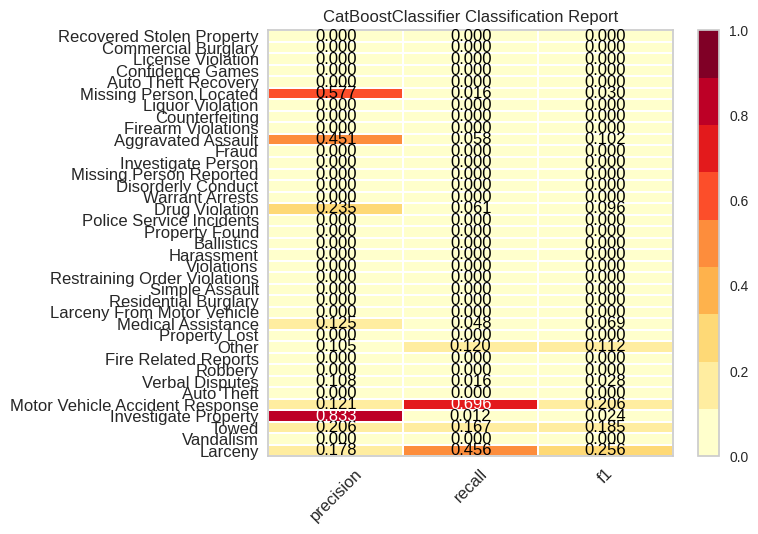

In [ ]:
from yellowbrick.contrib.wrapper import wrap
clf = CatBoostClassifier(iterations=200,max_depth=6,random_seed=42,learning_rate=0.01,custom_loss=['AUC', 'Accuracy'])

clf.fit(X_train, y_train,eval_set=(X_test, y_test),verbose=False,plot=True)
early_stop = clf.get_best_iteration()
print("Early stop iteration : ",early_stop)

result = clf.predict(X_test)
df_clf_prob = pd.DataFrame(clf.predict_proba(X_test),columns=Classes)


ac_sc = accuracy_score(y_test, result)
rc_sc = recall_score(y_test, result, average="weighted")
pr_sc = precision_score(y_test, result, average="weighted")
f1_sc = f1_score(y_test, result, average='micro')
confusion_m = confusion_matrix(y_test, result)

print("========== CATBOOST Results ==========")
print("Accuracy    : ", ac_sc)
print("Recall      : ", rc_sc)
print("Precision   : ", pr_sc)
print("F1 Score    : ", f1_sc)
print("Confusion Matrix: ")
print(confusion_m)

target_names = Classes

clf_wrap = wrap(clf)
visualizer = ClassificationReport(clf_wrap, classes=target_names)
visualizer.fit(X=X_train, y=y_train)     # Fit the training data to the visualizer
visualizer.score(X_test,y_test)       # Evaluate the model on the test data

print('================= Classification Report =================')
print('')
print(classification_report(y_test, result, target_names=target_names))

g = visualizer.poof()


In [ ]:
df_cnn_prob.head()

,Larceny,Vandalism,Towed,Investigate Property,Motor Vehicle Accident Response,Auto Theft,Verbal Disputes,Robbery,Fire Related Reports,Other,...,Aggravated Assault,Firearm Violations,Counterfeiting,Liquor Violation,Missing Person Located,Auto Theft Recovery,Confidence Games,License Violation,Commercial Burglary,Recovered Stolen Property
0,0.048543,0.051182,0.023266,0.035938,0.087836,0.017890,0.061766,0.014901,0.009782,0.088941,...,0.023684,0.009207,0.006749,0.006862,0.021790,0.007317,0.012233,0.005298,0.005476,0.007271
1,0.107742,0.040523,0.046485,0.028480,0.074244,0.011518,0.013307,0.022149,0.008497,0.072378,...,0.031446,0.006744,0.007410,0.006529,0.009541,0.005838,0.014050,0.019498,0.011410,0.007767
2,0.036382,0.055506,0.029871,0.037522,0.081909,0.019328,0.073310,0.013986,0.009727,0.089319,...,0.024176,0.010055,0.006549,0.006163,0.026886,0.008098,0.011444,0.004839,0.005815,0.007616
3,0.036592,0.054638,0.020664,0.037329,0.080502,0.019387,0.080490,0.014888,0.009693,0.086788,...,0.025406,0.010192,0.006803,0.005442,0.027925,0.007522,0.012410,0.004663,0.005254,0.007376
4,0.168621,0.028488,0.020006,0.022370,0.057305,0.012672,0.012723,0.016647,0.007338,0.071523,...,0.022087,0.007432,0.007998,0.006976,0.008750,0.005251,0.015667,0.011885,0.007476,0.007837


**XGBOOST**

[12:44:09] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

========== XGB Results ==========
Accuracy    :  0.17514001504639304
Recall      :  0.17514001504639304
Precision   :  0.20295341634723463
F1 Score    :  0.17514001504639304
Confusion Matrix: 
[[2632   15  207 ...    6    0    0]
 [ 426   30  157 ...    2    1    0]
 [ 327    8  656 ...    1    0    0]
 ...
 [ 156    1    1 ...   14    0    0]
 [  86    1   12 ...    1    1    0]
 [  63    0   12 ...    0    0    0]]
================= Classification Report =================

                                 precision    recall  f1-score   support

                        Larceny       0.22      0.51      0.31      5195
                      Vandalism       0.11      0.01      0.02      2934
                          Towed       0.25      0.30      0.27      2207
           Investigate Property       0.42      0.11      0.17      2093
Motor Vehicle Accident Response       0.14      0.59      0.23      62

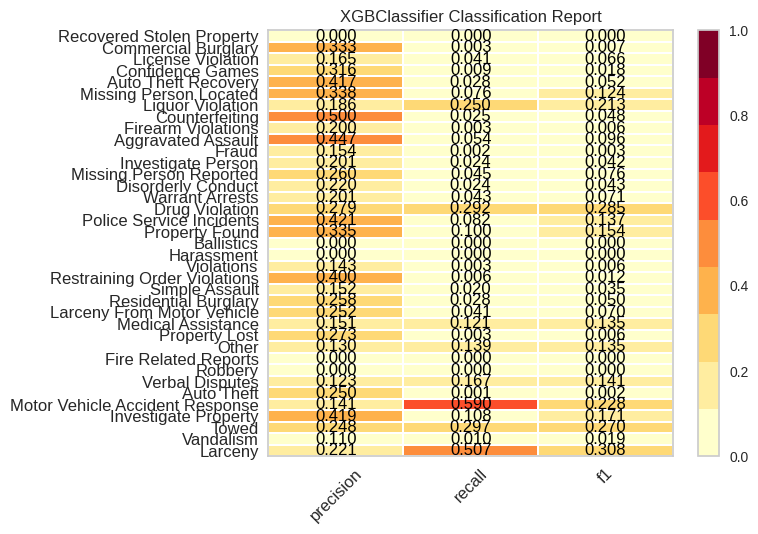

In [ ]:
xgb = XGBClassifier(booster =  'gbtree',
                        n_jobs = 4,
                        objective = 'multi:softmax',
                        silent = 0,
                        subsample = 1,
                        learning_rate = 0.01,
                        max_depth = 6,
                        min_child_weight = 2,
                        colsample_bytree = 1,
                        n_estimators= 200,
                        reg_lambda= 1)

xgb.fit(X_train, y_train)

result = xgb.predict(X_test)
df_xgb_prob = pd.DataFrame(xgb.predict_proba(X_test),columns=Classes)



ac_sc = accuracy_score(y_test, result)
rc_sc = recall_score(y_test, result, average="weighted")
pr_sc = precision_score(y_test, result, average="weighted")
f1_sc = f1_score(y_test, result, average='micro')
confusion_m = confusion_matrix(y_test, result)

print("========== XGB Results ==========")
print("Accuracy    : ", ac_sc)
print("Recall      : ", rc_sc)
print("Precision   : ", pr_sc)
print("F1 Score    : ", f1_sc)
print("Confusion Matrix: ")
print(confusion_m)

target_names = Classes
visualizer = ClassificationReport(xgb, classes=target_names)
visualizer.fit(X=X_train, y=y_train)     # Fit the training data to the visualizer
visualizer.score(X_test,y_test)       # Evaluate the model on the test data

print('================= Classification Report =================')
print('')
print(classification_report(y_test, result, target_names=target_names))

g = visualizer.poof()

In [ ]:
df_xgb_prob.head()


,Larceny,Vandalism,Towed,Investigate Property,Motor Vehicle Accident Response,Auto Theft,Verbal Disputes,Robbery,Fire Related Reports,Other,...,Aggravated Assault,Firearm Violations,Counterfeiting,Liquor Violation,Missing Person Located,Auto Theft Recovery,Confidence Games,License Violation,Commercial Burglary,Recovered Stolen Property
0,0.040002,0.044136,0.018681,0.033336,0.071224,0.018559,0.064635,0.017293,0.015025,0.071633,...,0.025853,0.013938,0.011107,0.010152,0.022892,0.013185,0.014535,0.009744,0.010301,0.011389
1,0.144020,0.035789,0.067489,0.022124,0.049560,0.011851,0.011084,0.019935,0.010229,0.054416,...,0.024263,0.010311,0.010554,0.009972,0.010785,0.009499,0.018866,0.015451,0.015636,0.013019
2,0.031432,0.047269,0.036552,0.036518,0.070562,0.021901,0.066216,0.015544,0.016858,0.073519,...,0.025739,0.015027,0.011203,0.010023,0.022798,0.013861,0.014160,0.009759,0.010318,0.012510
3,0.028621,0.053318,0.019082,0.034193,0.069333,0.022233,0.071655,0.021699,0.013416,0.071190,...,0.028177,0.015603,0.011336,0.010234,0.031460,0.012777,0.013264,0.009964,0.010535,0.012773
4,0.119051,0.028863,0.015341,0.021368,0.044867,0.017153,0.028205,0.022388,0.011340,0.048701,...,0.024683,0.012014,0.013720,0.011278,0.011507,0.010121,0.028314,0.044835,0.012218,0.013786


**TABNET**

In [ ]:
from yellowbrick.contrib.wrapper import wrap
trch = TabNetClassifier(
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=0.001),
        scheduler_params={
            "step_size":10, # how to use learning rate scheduler
            "gamma":0.9
        },
        scheduler_fn=torch.optim.lr_scheduler.StepLR,
        mask_type='entmax', # "sparsemax",
        verbose=25 # print every 25 epochs
    )

    # fit the model
trch.fit(
        X_train,y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_name=['train', 'valid'],
        eval_metric=['accuracy'],
        max_epochs=25, patience=20,
        batch_size=128,
        num_workers=4,
        weights=1,
        drop_last=False
    )


result = trch.predict(X_test)
df_torch_prob = pd.DataFrame(trch.predict_proba(X_test),columns=Classes)


ac_sc = accuracy_score(y_test, result)
rc_sc = recall_score(y_test, result, average="weighted")
pr_sc = precision_score(y_test, result, average="weighted")
f1_sc = f1_score(y_test, result, average='micro')
confusion_m = confusion_matrix(y_test, result)

print("========== TABNET Results ==========")
print("Accuracy    : ", ac_sc)
print("Recall      : ", rc_sc)
print("Precision   : ", pr_sc)
print("F1 Score    : ", f1_sc)
print("Confusion Matrix: ")
print(confusion_m)


epoch 0  | loss: 3.66293 | train_accuracy: 0.04005 | valid_accuracy: 0.04041 |  0:01:12s

Early stopping occurred at epoch 20 with best_epoch = 0 and best_valid_accuracy = 0.04041
========== TABNET Results ==========
Accuracy    :  0.040407924433670486
Recall      :  0.040407924433670486
Precision   :  0.032775727902158255
F1 Score    :  0.040407924433670486
Confusion Matrix: 
[[514  10 586 ... 949   0   0]
 [261   9 311 ... 525   0   0]
 [203   4 286 ... 513   0   0]
 ...
 [ 26   2  34 ...  87   0   0]
 [ 35   1  33 ...  77   0   0]
 [ 36   1  29 ...  37   0   0]]


In [ ]:
df_torch_prob.head()

,Larceny,Vandalism,Towed,Investigate Property,Motor Vehicle Accident Response,Auto Theft,Verbal Disputes,Robbery,Fire Related Reports,Other,...,Aggravated Assault,Firearm Violations,Counterfeiting,Liquor Violation,Missing Person Located,Auto Theft Recovery,Confidence Games,License Violation,Commercial Burglary,Recovered Stolen Property
0,0.026689,0.026154,0.026514,0.026853,0.027257,0.027358,0.027867,0.026544,0.027373,0.026851,...,0.026838,0.027963,0.027156,0.026442,0.027522,0.027873,0.026919,0.027021,0.026353,0.027622
1,0.027465,0.027716,0.026638,0.027442,0.028420,0.026803,0.028410,0.026612,0.025864,0.025470,...,0.027710,0.027882,0.027103,0.027114,0.027625,0.025100,0.026514,0.029677,0.025732,0.028014
2,0.020720,0.018773,0.020763,0.024367,0.028752,0.033364,0.038404,0.020562,0.039923,0.020218,...,0.028041,0.036621,0.023875,0.016827,0.032657,0.034673,0.026636,0.030100,0.019089,0.034758
3,0.027027,0.027027,0.027027,0.027027,0.027027,0.027027,0.027027,0.027027,0.027027,0.027027,...,0.027027,0.027027,0.027027,0.027027,0.027027,0.027027,0.027027,0.027027,0.027027,0.027027
4,0.021365,0.020818,0.020635,0.028648,0.028659,0.025495,0.032677,0.029256,0.025336,0.033062,...,0.027107,0.030809,0.031905,0.024300,0.030662,0.030672,0.024853,0.022815,0.023135,0.026392


**CNN XGB**

Epoch 1/20
7477/7477 [==============================] - 56s 7ms/step - loss: 3.2033 - accuracy: 0.1065 - val_loss: 3.1679 - val_accuracy: 0.1138
Epoch 2/20
7477/7477 [==============================] - 29s 4ms/step - loss: 3.1768 - accuracy: 0.1120 - val_loss: 3.1630 - val_accuracy: 0.1165
Epoch 3/20
7477/7477 [==============================] - 28s 4ms/step - loss: 3.1685 - accuracy: 0.1144 - val_loss: 3.1537 - val_accuracy: 0.1182
Epoch 4/20
7477/7477 [==============================] - 33s 4ms/step - loss: 3.1594 - accuracy: 0.1166 - val_loss: 3.1397 - val_accuracy: 0.1195
Epoch 5/20
7477/7477 [==============================] - 31s 4ms/step - loss: 3.1499 - accuracy: 0.1198 - val_loss: 3.1332 - val_accuracy: 0.1259
Epoch 6/20
7477/7477 [==============================] - 28s 4ms/step - loss: 3.1428 - accuracy: 0.1230 - val_loss: 3.1267 - val_accuracy: 0.1260
Epoch 7/20
7477/7477 [==============================] - 29s 4ms/step - loss: 3.1384 - accuracy: 0.1239 - val_loss: 3.1223 - val_ac

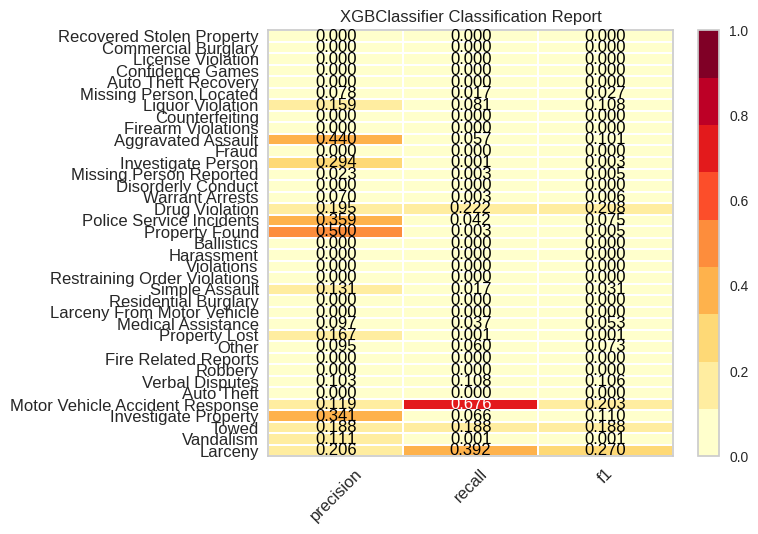

In [ ]:

# Reshape data for 1D CNN
X_train_scaled_re = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_scaled_re = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Create 1D CNN model
model = Sequential()
model.add(Conv1D(32, 3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(2))
model.add(Conv1D(64, 3, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(Classes), activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train 1D CNN model
model.fit(X_train_scaled_re, y_train, epochs=20, batch_size=32, validation_data=(X_test_scaled_re, y_test))

# Extract feature layer from 1D CNN model
feature_layer_model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-3].output)
X_train_features = feature_layer_model.predict(X_train_scaled_re)
X_test_features = feature_layer_model.predict(X_test_scaled_re)

# Create XGBoostClassifier
xgb_clf = XGBClassifier(booster =  'gbtree',
                        n_jobs = 4,
                        objective = 'multi:softmax',
                        silent = 0,
                        subsample = 1,
                        learning_rate = 0.01,
                        max_depth = 6,
                        min_child_weight = 2,
                        colsample_bytree = 1,
                        n_estimators= 300,
                        reg_lambda= 1)

# Fit XGBoostClassifier using 1D CNN features
xgb_clf.fit(X_train_features, y_train)

# Evaluate XGBoostClassifier on test data
accuracy = xgb_clf.score(X_test_features, y_test)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

result = xgb_clf.predict(X_test_features)
df_xgb_cnn_prob = pd.DataFrame(xgb_clf.predict_proba(X_test_features),columns=Classes)


ac_sc = accuracy_score(y_test, result)
rc_sc = recall_score(y_test, result, average="weighted")
pr_sc = precision_score(y_test, result, average="weighted")
f1_sc = f1_score(y_test, result, average='micro')
confusion_m = confusion_matrix(y_test, result)

print("========== cnn xgb Results ==========")
print("Accuracy    : ", ac_sc)
print("Recall      : ", rc_sc)
print("Precision   : ", pr_sc)
print("F1 Score    : ", f1_sc)
print("Confusion Matrix: ")
print(confusion_m)

target_names = Classes
visualizer = ClassificationReport(xgb_clf, classes=target_names)
visualizer.fit(X=X_train, y=y_train)     # Fit the training data to the visualizer
visualizer.score(X_test_features,y_test)       # Evaluate the model on the test data

print('================= Classification Report =================')
print('')
print(classification_report(y_test, result, target_names=target_names))

g = visualizer.poof()



In [ ]:
df_xgb_cnn_prob.head()

,Larceny,Vandalism,Towed,Investigate Property,Motor Vehicle Accident Response,Auto Theft,Verbal Disputes,Robbery,Fire Related Reports,Other,...,Aggravated Assault,Firearm Violations,Counterfeiting,Liquor Violation,Missing Person Located,Auto Theft Recovery,Confidence Games,License Violation,Commercial Burglary,Recovered Stolen Property
0,0.048090,0.053208,0.017765,0.031435,0.085460,0.019714,0.063906,0.017749,0.010055,0.077262,...,0.023524,0.011356,0.008093,0.006872,0.022646,0.008910,0.012543,0.006387,0.006909,0.009007
1,0.083149,0.038824,0.020425,0.026662,0.054530,0.009264,0.008248,0.024588,0.009080,0.066946,...,0.029015,0.007462,0.009100,0.010751,0.007923,0.006858,0.019191,0.044025,0.016057,0.010034
2,0.044267,0.055357,0.021632,0.031975,0.080278,0.019254,0.063547,0.014573,0.011292,0.078145,...,0.021489,0.009154,0.007411,0.006583,0.022761,0.008999,0.012572,0.006373,0.006817,0.008988
3,0.025239,0.054337,0.020252,0.038695,0.074822,0.023866,0.078750,0.017585,0.011691,0.087519,...,0.027848,0.012998,0.007645,0.007186,0.030106,0.010098,0.011046,0.006192,0.006271,0.009014
4,0.117186,0.023792,0.009097,0.021211,0.035040,0.015167,0.012428,0.022234,0.007608,0.071030,...,0.028972,0.011949,0.008522,0.008600,0.007602,0.008925,0.020166,0.018089,0.008404,0.010658


**Bagging Classifier**

========== Bagging Results ==========
Accuracy    :  0.20344395218590655
Recall      :  0.20344395218590655
Precision   :  0.17671367204489077
F1 Score    :  0.20344395218590655
Confusion Matrix: 
[[2509  116  142 ...   15    6    6]
 [ 286  253  109 ...   12    9    4]
 [ 169   93  688 ...    3    1    0]
 ...
 [  84    4    2 ...   39    0    0]
 [  79   18    9 ...    2   16    1]
 [  50    5    2 ...    0    0    3]]
================= Classification Report =================

                                 precision    recall  f1-score   support

                        Larceny       0.29      0.48      0.36      5195
                      Vandalism       0.11      0.09      0.10      2934
                          Towed       0.31      0.31      0.31      2207
           Investigate Property       0.25      0.16      0.19      2093
Motor Vehicle Accident Response       0.25      0.43      0.31      6204
                     Auto Theft       0.05      0.02      0.03       865
    

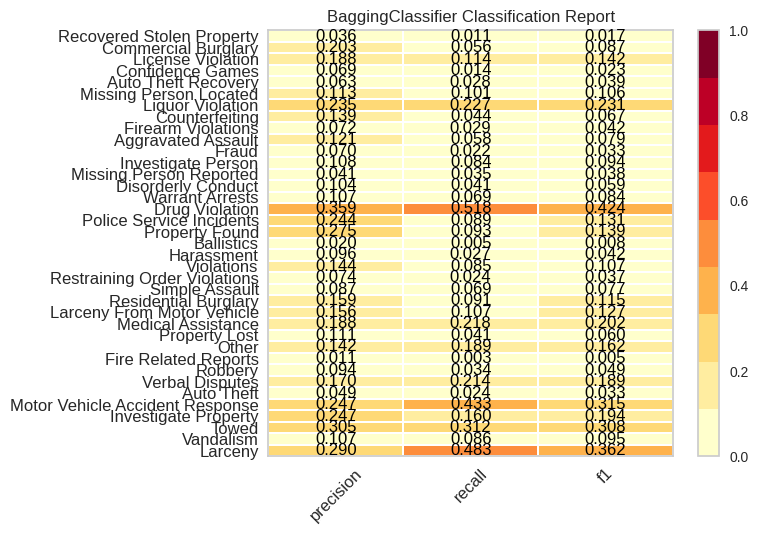

In [ ]:
bagg = BaggingClassifier(n_jobs = -1,
                         n_estimators = 100,
                         max_features = 3,
                        )

bagg.fit(X_train, y_train)


result = bagg.predict(X_test)
df_bagg_prob = pd.DataFrame(bagg.predict_proba(X_test),columns=Classes)

ac_sc = accuracy_score(y_test, result)
rc_sc = recall_score(y_test, result, average="weighted")
pr_sc = precision_score(y_test, result, average="weighted")
f1_sc = f1_score(y_test, result, average='micro')
confusion_m = confusion_matrix(y_test, result)

print("========== Bagging Results ==========")
print("Accuracy    : ", ac_sc)
print("Recall      : ", rc_sc)
print("Precision   : ", pr_sc)
print("F1 Score    : ", f1_sc)
print("Confusion Matrix: ")
print(confusion_m)

target_names = Classes
visualizer = ClassificationReport(bagg, classes=target_names)
visualizer.fit(X=X_train, y=y_train)     # Fit the training data to the visualizer
visualizer.score(X_test,y_test)       # Evaluate the model on the test data

print('================= Classification Report =================')
print('')
print(classification_report(y_test, result, target_names=target_names))

g = visualizer.poof()

In [ ]:
df_bagg_prob.head()

,Larceny,Vandalism,Towed,Investigate Property,Motor Vehicle Accident Response,Auto Theft,Verbal Disputes,Robbery,Fire Related Reports,Other,...,Aggravated Assault,Firearm Violations,Counterfeiting,Liquor Violation,Missing Person Located,Auto Theft Recovery,Confidence Games,License Violation,Commercial Burglary,Recovered Stolen Property
0,0.031412,0.096326,0.038962,0.005001,0.040606,0.006339,0.052061,0.011009,0.000618,0.078225,...,0.025903,0.003985,0.001160,0.001653,0.003606,0.002819,0.000489,0.000273,0.000322,0.000837
1,0.342580,0.028025,0.021162,0.011062,0.026554,0.011544,0.008131,0.005725,0.001077,0.051256,...,0.011723,0.001057,0.005670,0.000805,0.002057,0.000158,0.035288,0.002423,0.004294,0.001208
2,0.008134,0.130538,0.025023,0.035213,0.047923,0.002818,0.120411,0.010219,0.028046,0.048727,...,0.009349,0.009815,0.009962,0.000374,0.047198,0.007238,0.000514,0.000459,0.001874,0.000318
3,0.010900,0.089098,0.013132,0.114112,0.101160,0.017167,0.058121,0.008130,0.001230,0.054596,...,0.041859,0.000974,0.000318,0.000253,0.116053,0.000482,0.007862,0.000197,0.000408,0.002175
4,0.096684,0.064910,0.018981,0.065473,0.040472,0.016676,0.051584,0.009680,0.005587,0.036410,...,0.010444,0.002251,0.002707,0.001606,0.084912,0.002899,0.005232,0.009156,0.001914,0.001570


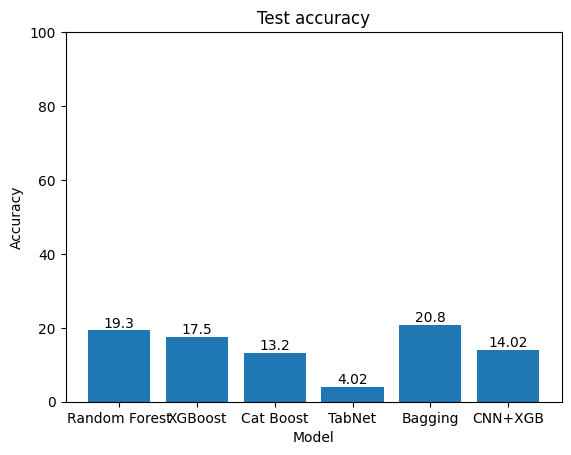

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

X = ['Random Forest','XGBoost','Cat Boost','TabNet', 'Bagging','CNN+XGB']
accuracy = [19.3,17.5,13.2,4.02,20.8,14.02]

fig, ax = plt.subplots()


# Create the bar chart
ax.bar(X, accuracy)

# Annotate the values
for i, v in enumerate(accuracy):
    ax.annotate(str(v), xy=(i, v), ha='center', va='bottom')

# Add title and axis labels
plt.ylim(0, 100)
plt.grid(visible=False)
ax.set_title('Test accuracy')
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')

plt.show()